In [1]:
import numpy as np
from matplotlib import colors
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import rc
import pickle
import signac as sg
from scipy.special import gamma
import copy as copy
import scipy
from global_functions import adjustmaps
import h5py
from scipy.interpolate import make_lsq_spline
from itertools import product

In [2]:
# Update global plotting parameters
rc('axes', labelsize=16)  # Font size for x and y labels
rc('axes', titlesize=16)
rc('xtick', labelsize=15)  # Font size for x-axis tick labels
rc('ytick', labelsize=15)  # Font size for y-axis tick labels
rc('lines', markersize=12)  # Set the default marker size to 10 points
rc('legend', fontsize=14)

# Define/load things non-specific to a given set of results
metric = "P_s"
Aeff = 1.0
t_final = 600
ncell_tot = 87_993
c = 1.42
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
tau_vec = b_vec * gamma(1+1/c)
tau_step = np.diff(tau_vec)[0] / 2
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))
tauc_methods = ["flat"]

In [3]:
def set_globals(results_pre):
    if results_pre == 'meta_mean_results':
        globals()['metric_lab'] = f'$<{metric}>_{{meta}}$'
    else:
        globals()['metric_lab'] = f'$P(<{metric}>_k \geq 0.5)$'
    globals()['fn_prefix'] = f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
    globals()['fig_prefix'] = f"{results_pre}/figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"

    # Load things saved specific to these results
    with open(fn_prefix + 'metric_data.pkl', 'rb') as handle:
        globals()['metric_data'] = pickle.load(handle)
    globals()['all_metric'] = metric_data['all_metric']
    globals()['all_tau'] = np.load(f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/all_tau.npy")
    globals()['C_vec'] = np.load(fn_prefix + "C_vec.npy")
    globals()['ncell_vec'] = np.load(fn_prefix + "ncell_vec.npy")
    globals()['slice_left_all'] = np.load(fn_prefix + "slice_left_all.npy")
    eps_axes = {}
    with h5py.File(fn_prefix + "/eps_axes.h5", "r") as handle:
        for key in handle.keys():
            eps_axes.update({key: handle[key][()]})
    globals()['eps_axes'] = eps_axes

### Preprocess robustness

In [ ]:
# for results_pre in ['meta_mean_results', 'gte_thresh_results']:
for results_pre in ['meta_mean_results']:
    # Load things saved specific to these results
    set_globals(results_pre)

    # Collect <metric> across all state variables and uncertainty parameterizations
    shape = [len(eps_axes[key]) for key in eps_axes.keys()] 
    shape += [len(C_vec), len(ncell_vec), len(slice_left_all)]
    phase_full = np.ones((shape)) * np.nan
    with h5py.File(fn_prefix + "phase_flat.h5", "r") as phase_handle:
        for eps_params in product(*eps_axes.values()):
            # Create a dictionary of indices along with values for the current combination
            eps_params_dict = {
                key: (index, np.round(value, 3)) for key, values in zip(eps_axes.keys(), eps_axes.values())
                for index, value in enumerate(values) if value == eps_params[list(eps_axes.keys()).index(key)]
            }

            # Get phase slice at this epsilon parameterization
            data_key = f"{eps_params_dict['mu_tau'][1]}/{eps_params_dict['sigm_tau'][1]}/"
            data_key += f"{eps_params_dict['mu_tauc'][1]}/{eps_params_dict['sigm_tauc'][1]}/phase"
            phase_slice = phase_handle[data_key][:]

            # Add them to collective phase_all
            eps_indices = [val[0] for val in eps_params_dict.values()]
            index_tuple = tuple(eps_indices) + (slice(None), slice(None), slice(None))
            phase_full[index_tuple] = phase_slice
    # Save full phase matrix to file
    np.save(fn_prefix + "phase_full.npy", phase_full)

    rob_thresh_vec = np.linspace(min(phase_full.flatten()), max(phase_full.flatten()), 100)
    np.save(fn_prefix + "rob_thresh_vec.npy", rob_thresh_vec)
    allrob = np.ones((rob_thresh_vec.size, C_vec.size, ncell_vec.size, slice_left_all.size)) * np.nan
    maxrob = np.ones((len(rob_thresh_vec), len(C_vec))) * np.nan
    argmaxrob = np.ones((len(rob_thresh_vec), len(C_vec), 2)) * np.nan
    tot_eps_samples = np.cumprod([len(axis) for axis in eps_axes.values()])[-1]
    zero_eps_i = [np.argwhere(ax == 0)[0][0] for ax in eps_axes.values()]
    for (thresh_i, thresh), (C_i, C) in product(enumerate(rob_thresh_vec), 
                                                enumerate(C_vec)):
        rob_slice = np.ones((len(ncell_vec), len(slice_left_all))) * np.nan
        for (ncell_i, ncell), (sl_i, sl) in product(enumerate(ncell_vec),
                                                    enumerate(slice_left_all)):
            # First, check that this result is feasible with zero uncertainty
            # Skip and keep at nan if not feasible
            metric_zero_eps = phase_full[tuple(zero_eps_i + [C_i, ncell_i, sl_i])]
            if np.isnan(metric_zero_eps) or (metric_zero_eps < thresh): continue
            # Now, get the robstness at this (C,ncell,slice_left) coordinate and store
            counts = np.count_nonzero(phase_full[..., C_i, ncell_i, sl_i] >= thresh)
            robustness = counts / tot_eps_samples
            rob_slice[ncell_i, sl_i] = robustness
        allrob[thresh_i, C_i] = rob_slice
        if np.any(~np.isnan(rob_slice)):
            # Store the max robustness at this (thresh, C) coordinate
            maxrob[thresh_i, C_i] = np.nanmax(rob_slice)
            # Also store the optimal param indices
            optimal_param_i = np.unravel_index(np.nanargmax(rob_slice, axis=None), rob_slice.shape)
            argmaxrob[thresh_i, C_i] = optimal_param_i
    # Save maxrob and argmaxrob to files
    np.save(fn_prefix + "maxrob.npy", maxrob)
    np.save(fn_prefix + "argmaxrob.npy", argmaxrob)

### $\text{max}(\omega)$ vs target $<\text{metric}_{meta}>$

In [ ]:
set_globals('meta_mean_results')
maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")

cbar_labels = [fr"optimally robust range fraction for intervention",
               fr"optimally robust slice left for intervention"]
for opt_i in range(2):
    fig, ax = plt.subplots(1, figsize=(11,7))
    colormap = copy.copy(cm.RdPu_r)
    if opt_i == 0:
        vmax = 1; vmin = 0
    else:
        # vmax = max(slice_left_all); vmin = min(slice_left_all)
        # vmax = slice_left_all[np.nanmax(argmaxrob[:,9,1]).astype(int)] / ncell_tot; vmin=0
        vmax = 1; vmin = 0
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)

    all_markers = ['o','^','s','D']
    all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
    C_i_samples = [0,3,6,9]
    # C_i_samples = [9]
    for line_i, C_i in enumerate(C_i_samples):
        plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
        c_vec = np.ones(len(rob_thresh_vec)) * np.nan
        for thresh_i, thresh in enumerate(rob_thresh_vec):
            if thresh_i % 2 == 0: continue
            # Get the maximum robustness across (ncell, sl) at this C 
            if maxrob[thresh_i, C_i] < 1:
                plot_vec[thresh_i] = maxrob[thresh_i, C_i]
            if not np.isnan(plot_vec[thresh_i]):
                if opt_i == 0:
                    c_vec[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
                else:
                    c_vec[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
        scatter = ax.scatter(rob_thresh_vec, plot_vec, cmap=colormap, norm=normalize,
                            c=c_vec, marker=all_markers[line_i])#, s=60)
        ax.scatter([], [], label=fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}", 
                   s=60, c='black', marker=all_markers[line_i])
    cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
    cbar.set_label(cbar_labels[opt_i], rotation=-90, labelpad=30)
    ax.set_ylabel(fr"$\text{{max}}(\omega)$")
    ax.set_xlabel(fr"target {metric_lab}")
    ax.legend()
    ax.axvline(0.5, ls='--', c='k', lw=5)
    fn = fig_prefix + f"/maxrob_{opt_i}.png"
    # fig.savefig(fn, bbox_inches='tight')

In [ ]:
cbar_labels = [fr"optimal range fraction for intervention",
               fr"optimal slice left for intervention"]
for opt_i in range(2):
    fig, ax = plt.subplots(1, figsize=(11,7))
    colormap = copy.copy(cm.RdPu_r)
    if opt_i == 0:
        vmax = 1; vmin = 0
    else:
        # vmax = max(slice_left_all); vmin = min(slice_left_all)
        # vmax = slice_left_all[np.nanmax(argmaxrob[:,9,1]).astype(int)] / ncell_tot; vmin=0
        vmax = 1; vmin = 0
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)

    all_markers = ['o','^','s','D']
    all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
    C_i_samples = [0,3,6,9]
    # C_i_samples = [9]
    for line_i, C_i in enumerate(C_i_samples):
        plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
        c_vec = np.ones(len(rob_thresh_vec)) * np.nan
        for thresh_i, thresh in enumerate(rob_thresh_vec):
            if thresh_i % 2 == 0: continue
            # Get the maximum robustness across (ncell, sl) at this C 
            if maxrob[thresh_i, C_i] < 1:
                plot_vec[thresh_i] = maxrob[thresh_i, C_i]
            if not np.isnan(plot_vec[thresh_i]):
                if opt_i == 0:
                    c_vec[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
                else:
                    c_vec[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
        scatter = ax.scatter(plot_vec, rob_thresh_vec, cmap=colormap, norm=normalize,
                            c=c_vec, marker=all_markers[line_i])#, s=60)
        ax.scatter([], [], label=fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}", 
                   s=60, c='black', marker=all_markers[line_i])
    cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
    cbar.set_label(cbar_labels[opt_i], rotation=-90, labelpad=30)
    ax.set_xlabel(fr"$\omega$ requirement")
    ax.set_ylabel(fr"max(target {metric_lab})")
    ax.legend()
    # ax.axvline(0.5, ls='--', c='k', lw=5)
    # fn = fig_prefix + f"/maxrob_{opt_i}.png"
    # fig.savefig(fn, bbox_inches='tight')

### Compare optimal strategies between metapop metrics

In [ ]:
fig, ax = plt.subplots(1, figsize=(11,7))
# colormap = copy.copy(cm.RdPu_r)
# colormap = copy.copy(cm.PuBu_r)
colormap = copy.copy(cm.copper)
vmin = 0; vmax = 1
normalize = colors.Normalize(vmin=vmin, vmax=vmax)
colormap_2 = copy.copy(cm.YlGn_r)
normalize_2 = colors.Normalize(vmin=vmin, vmax=vmax)
C_i = 9
markers = ['o', '^']
res_labs = [f'$<{metric}>_{{meta}}$', f'$P(<{metric}>_k \geq 0.5)$']
# for res_i, results_pre in enumerate(['meta_mean_results']):#, 'gte_thresh_results']):
for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    opt_ncell = np.ones_like(rob_thresh_vec) * np.nan
    opt_sl = np.ones_like(rob_thresh_vec) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if maxrob[thresh_i, C_i] < 1:
            opt_ncell[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][0])]
            opt_sl[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][1])]
    opt_ncell = opt_ncell / ncell_tot
    opt_sl = opt_sl / ncell_tot
    ax.plot(opt_ncell, opt_sl, c='k', zorder=-1)
    # scatter = ax.scatter(opt_ncell, opt_sl, cmap=colormap_2, norm=normalize_2, c=rob_thresh_vec, marker=markers[res_i], s=600)
    scatter = ax.scatter(opt_ncell, opt_sl, cmap=colormap, norm=normalize, c=maxrob[:, C_i], marker=markers[res_i], s=200)
    ax.scatter([], [], c='k', marker=markers[res_i], label=res_labs[res_i])
cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
cbar.set_label(r"$\omega$ requirement", rotation=-90, labelpad=30)
# ax.set_xlabel(fr"optimal $n_{{cell}}$")
ax.set_xlabel(fr"optimal slice size for alteration")
# ax.set_ylabel(fr"optimal $sl$")
ax.set_ylabel(fr"optimal slice starting point")
ax.legend()
# ymin = -0.05; ymax = 1
ymin = min(slice_left_all/ncell_tot) - np.diff(slice_left_all/ncell_tot)[0]
ymax = max(slice_left_all/ncell_tot)
# ymax = 0.6
ax.set_ylim(ymin,ymax)
xmin = min(ncell_vec/ncell_tot)
# xmin = ncell_vec[5]/ncell_tot
xmax = max(ncell_vec/ncell_tot)
ax.set_xlim(xmin, xmax)
grid_style = {
    'color': 'k', 
    'linewidth': 1, 
    'linestyle': '-',
    'alpha': 0.2
}
ax.vlines(ncell_vec/ncell_tot, ymin, ymax, zorder=-1, **grid_style)
ax.hlines(slice_left_all/ncell_tot, xmin, xmax, zorder=-1, **grid_style)
sl_constraint = 1-(ncell_vec/ncell_tot)
# ax.plot(ncell_vec/ncell_tot, sl_constraint)
ax.fill_between(ncell_vec/ncell_tot, np.repeat(1, ncell_vec.size), sl_constraint, where=(1 > sl_constraint), color='gray', alpha=1, label='Shaded Area')

In [ ]:
fig, ax = plt.subplots(1, figsize=(11,7))
# colormap = copy.copy(cm.RdPu_r)
# colormap = copy.copy(cm.PuBu_r)
colormap = copy.copy(cm.copper)
vmin = 0; vmax = 1
normalize = colors.Normalize(vmin=vmin, vmax=vmax)
colormap_2 = copy.copy(cm.YlGn_r)
normalize_2 = colors.Normalize(vmin=vmin, vmax=vmax)
C_i = 9
markers = ['o', '^']
res_labs = [f'$<{metric}>_{{meta}}$', f'$P(<{metric}>_k \geq 0.5)$']
# for res_i, results_pre in enumerate(['meta_mean_results']):#, 'gte_thresh_results']):
for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    opt_ncell = np.ones_like(rob_thresh_vec) * np.nan
    opt_sl = np.ones_like(rob_thresh_vec) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if maxrob[thresh_i, C_i] < 1:
            opt_ncell[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][0])]
            opt_sl[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][1])]
    opt_ncell = opt_ncell / ncell_tot
    opt_sl = opt_sl / ncell_tot
    # ax.plot(opt_sl, opt_ncell, c='k', zorder=-1)
    scatter = ax.scatter(opt_sl, opt_ncell, cmap=colormap, norm=normalize, c=maxrob[:, C_i], marker=markers[res_i], s=200)
    ax.scatter([], [], c='k', marker=markers[res_i], label=res_labs[res_i])
cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
cbar.set_label(r"$\omega$ requirement", rotation=-90, labelpad=30)
# ax.set_xlabel(fr"optimal $n_{{cell}}$")
ax.set_ylabel(fr"optimal range fraction for intervention")
# ax.set_ylabel(fr"optimal $sl$")
ax.set_xlabel(fr"optimal slice starting point")
ax.legend()
# ymin = -0.05; ymax = 1
xmin = min(slice_left_all/ncell_tot) - np.diff(slice_left_all/ncell_tot)[0]
# xmax = max(slice_left_all/ncell_tot)
xmax = slice_left_all[-23]/ncell_tot
ax.set_xlim(xmin,xmax)
# ymin = min(ncell_vec/ncell_tot)
# ymax = max(ncell_vec/ncell_tot)
ymin = ncell_vec[6] / ncell_tot
ymax = ncell_vec[-5] / ncell_tot
ax.set_ylim(ymin, ymax)
grid_style = {
    'color': 'k', 
    'linewidth': 1, 
    'linestyle': '-',
    'alpha': 0.15
}
ax.hlines(ncell_vec/ncell_tot, xmin, xmax, zorder=-1, **grid_style)
ax.vlines(slice_left_all[::2]/ncell_tot, ymin, ymax, zorder=-1, **grid_style)
# sl_constraint = 1-(ncell_vec/ncell_tot)
ncell_constraint = 1 - (slice_left_all/ncell_tot)
# ax.fill_between(ncell_vec/ncell_tot, np.repeat(1, ncell_vec.size), sl_constraint, where=(1 > sl_constraint), color='gray', alpha=1, label='Shaded Area')
ax.fill_between(slice_left_all/ncell_tot, np.repeat(1, slice_left_all.size), ncell_constraint, where=(1 > ncell_constraint), color='gray', alpha=1, label='Shaded Area')
fn = f"shared_figs/comparing_optima.png"
fig.savefig(fn, bbox_inches='tight')

#### max meta metric vs $\omega$ with both metrics on same plot

In [ ]:
cbar_labels = [fr"optimal range fraction for intervention",
               fr"optimal slice left for intervention"]
for opt_i in range(2):
    fig, ax = plt.subplots(1, figsize=(11,7))
    colormap = copy.copy(cm.RdPu_r)
    if opt_i == 0:
        vmax = 1; vmin = 0
    else:
        # vmax = max(slice_left_all); vmin = min(slice_left_all)
        # vmax = slice_left_all[np.nanmax(argmaxrob[:,9,1]).astype(int)] / ncell_tot; vmin=0
        vmax = 1; vmin = 0
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)

    all_markers = ['o','^','s','D']
    all_linestyles = ['dotted', 'dashdot', 'dashed', 'solid']
    C_i = 9
    # for line_i, C_i in enumerate(C_i_samples):
    for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
        set_globals(results_pre)
        maxrob = np.load(fn_prefix + "maxrob.npy")
        argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
        rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
        
        plot_vec = np.ones(len(rob_thresh_vec)) * np.nan
        c_vec = np.ones(len(rob_thresh_vec)) * np.nan
        for thresh_i, thresh in enumerate(rob_thresh_vec):
            if thresh_i % 2 == 0: continue
            # Get the maximum robustness across (ncell, sl) at this C 
            if maxrob[thresh_i, C_i] < 1:
                plot_vec[thresh_i] = maxrob[thresh_i, C_i]
            if not np.isnan(plot_vec[thresh_i]):
                if opt_i == 0:
                    c_vec[thresh_i] = ncell_vec[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
                else:
                    c_vec[thresh_i] = slice_left_all[int(argmaxrob[thresh_i, C_i][opt_i])] / ncell_tot
        scatter = ax.scatter(plot_vec, rob_thresh_vec, cmap=colormap, norm=normalize,
                            c=c_vec, marker=all_markers[res_i])#, s=60)
        ax.scatter([], [], label=fr"{metric_lab}", 
                   s=60, c='black', marker=all_markers[res_i])
    cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
    cbar.set_label(cbar_labels[opt_i], rotation=-90, labelpad=30)
    ax.set_xlabel(fr"$\omega$ requirement")
    ax.set_ylabel(fr"max(target meta metric)")
    ax.legend()
    # ax.axvline(0.5, ls='--', c='k', lw=5)
    # fn = fig_prefix + f"/maxrob_{opt_i}.png"
    # fig.savefig(fn, bbox_inches='tight')

#### Map change in optimal strategies between results

In [ ]:
fn = f"meta_mean_results/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/avg_tauc_k_rob.npy"
avg_tauc_k_rob_mmean = np.load(fn)
fn = f"gte_thresh_results/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/avg_tauc_k_rob.npy"
avg_tauc_k_rob_gtet = np.load(fn)

fig, ax = plt.subplots(1, figsize=(10,10))

# First replace nans with 0 so we can subtract
imshow_mat = np.where(np.isnan(avg_tauc_k_rob_gtet), 0, avg_tauc_k_rob_gtet) - np.where(np.isnan(avg_tauc_k_rob_mmean), 0, avg_tauc_k_rob_mmean)
# Now make pixels not in either map nan
nan_pixel_filt = np.isnan(avg_tauc_k_rob_gtet) & np.isnan(avg_tauc_k_rob_mmean)
imshow_mat[nan_pixel_filt] = np.nan
# Crop out border where all nans
nonzero_indices = np.nonzero(~np.isnan(imshow_mat))
row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
imshow_mat = imshow_mat[row_min:row_max + 1, col_min:col_max + 1]

vmin = np.nanmin(imshow_mat); vmax = np.nanmax(imshow_mat)
center = 0
cmap = cm.PuOr.copy()
# cmap = cm.PiYG.copy()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
cmap.set_bad(color='black', alpha=0.3)
imshow = ax.imshow(imshow_mat, cmap=cmap, norm=norm)
cbar = fig.colorbar(imshow, ax=ax, location="right", shrink=0.8)
ax.set_xlabel(fr"Change in $\hat{{\tau}}$ gte thresh minus mean")
ax.set_xticks([])
ax.set_yticks([])
# fn = fig_prefix + f"map_example.png"
# fig.savefig(fn, bbox_inches='tight')

### Work towards new map viz

In [4]:
# Read in maps and convert fdm to tau
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt]
mapindices = np.argwhere(maps_filt)
# mapindices = np.nonzero(maps_filt)
# tau_flat[tau_flat > max(tau_vec)] = max(tau_vec)
# tau_argsort = np.argsort(tau_flat)
# tau_sorted = sorted(tau_flat)
tau_argsort_ref = np.argsort(tau_flat)
tau_sorted = tau_flat[tau_argsort_ref] 

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_1774/4259901909.py:13: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)


#### Per cell corr to omega old

In [ ]:
from tqdm import tqdm
C_i = 9

# First, population matrix recording which cells are in optima for a range of omega requirement
omega_samples = np.linspace(0, 1, 50)
for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    # Select metric threshold indices as close as possible to desired omega samples
    closest_thresh_i = np.array([np.abs(maxrob[:,C_i] - val).argmin() for val in omega_samples])
    closest_thresh_i = []
    for i, omega in enumerate(omega_samples):
        closest_i = np.abs(maxrob[:,C_i] - omega).argmin()
        if maxrob[closest_i, C_i] == 1: continue
        closest_thresh_i.append(closest_i)
    closest_thresh_i = np.array(closest_thresh_i)
    # Filter out any repeats
    rpt_filt = np.concatenate(((np.diff(closest_thresh_i) == 0), [False]))
    closest_thresh_i = closest_thresh_i[~rpt_filt]
    # plt.plot(rob_thresh_vec, maxrob[:,9])
    # plt.scatter(rob_thresh_vec[closest_thresh_i], maxrob[:,C_i][closest_thresh_i])
    
    # For each omega sample, record which cells are included in optima 
    inoptima_vec = np.zeros((tau_flat.size, closest_thresh_i.size)).astype('bool')
    for omega_sample_i, metric_thresh_i in enumerate(closest_thresh_i):
        opt_ncell_i, opt_sl_i = argmaxrob[metric_thresh_i, C_i].astype(int)
        opt_ncell = ncell_vec[opt_ncell_i]
        opt_sl = slice_left_all[opt_sl_i]
        '''Note that we assume the tau axis of inoptima_vec is in sorted order'''
        inoptima_vec[opt_sl:opt_sl+opt_ncell, omega_sample_i] = True
    np.save(fn_prefix + "inoptima_vec.npy", inoptima_vec)
    
    # Now, fit a step function to each cell's data and store information based on that
    stepfit_values = np.ones(tau_flat.size) * np.nan
    total_inoptima = np.ones(tau_flat.size) * np.nan
    for k in tqdm(range(tau_flat.size)):
        # Retrieve and relabel cell k's data for fitting
        X = maxrob[:, C_i][closest_thresh_i]
        y = inoptima_vec[k]
        # Define fitting functions
        def step_function(x, threshold, value_low, value_high):
            return np.where(x < threshold, value_low, value_high)
        def mse_loss(params):
            """Mean squared error for the step function fit."""
            threshold = params[0]
            value_low = allowed_values[int(round(params[1]))]
            value_high = allowed_values[int(round(params[2]))]
            y_pred = step_function(X, threshold, value_low, value_high)
            return np.mean((y - y_pred) ** 2)
        # Perform fitting
        allowed_values = np.array([0, 1])
        initial_guess = [0.5, 0.5, 0.5]
        bounds = [(X.min(), X.max()), (0, allowed_values.size - 1), (0, allowed_values.size - 1)]
        result = scipy.optimize.differential_evolution(mse_loss, bounds)
        # Extract fitted parameters
        fitted_threshold = result.x[0]
        fitted_value_low = allowed_values[int(round(result.x[1]))]
        fitted_value_high = allowed_values[int(round(result.x[2]))]

        diff = fitted_value_high - fitted_value_low
        if diff > 0:
            stepfit_values[k] = fitted_threshold
            total_inoptima[k] = np.count_nonzero(y == 1)
        elif diff < 0:
            stepfit_values[k] = -fitted_threshold
            total_inoptima[k] = np.count_nonzero(y == 1)
        else:
            stepfit_values[k] = fitted_value_high
            if fitted_value_high == 1:
                total_inoptima[k] = inoptima_vec.shape[1]
            else:
                total_inoptima[k] = 0
    np.save(fn_prefix + "stepfit_values.npy", stepfit_values)
    np.save(fn_prefix + "total_inoptima.npy", total_inoptima)
    np.save(fn_prefix + "closest_thresh_i.npy", closest_thresh_i)

#### Per cell corr to omega

In [5]:
# Define functions used for determining best step fit
'''Note these actually are fit for the indices of allowed values, not the y values themselves'''
def step_function1(x, threshold, value_low, value_high):
    return np.where(x < threshold, value_low, value_high)
def step_function2(x, threshold1, threshold2, value_btwn, value_out):
    return np.where((x >= threshold1) & (x < threshold2), value_btwn, value_out)

def stepfit1(X, y, y0_i):
    def mse_loss(params):
        """Mean squared error for the step function fit."""
        threshold = params[0]
        value_low = allowed_values[int(round(params[1]))]
        value_high = allowed_values[int(round(params[2]))]
        y_pred = step_function1(X, threshold, value_low, value_high)
        return np.mean((y - y_pred) ** 2)
    initial_guess = [0.5, 0.5, 0.5]
    bounds = [(X.min(), X.max()), (y0_i, y0_i), (0, allowed_values.size - 1)]
    result = scipy.optimize.differential_evolution(mse_loss, bounds)
    return result
def stepfit2(X, y, y0_i):
    def mse_loss(params):
        threshold1 = params[0]
        threshold2 = params[1]
        value_btwn = allowed_values[int(round(params[2]))]
        value_out = allowed_values[int(round(params[3]))]
        y_pred = step_function2(X, threshold1, threshold2, value_btwn, value_out)
        return np.mean((y - y_pred) ** 2)
    initial_guess = [0.5, 0.5, 0.5, 0.5]
    bounds = [(X.min(), X.max()), (X.min(), X.max()), (0, allowed_values.size - 1), (y0_i, y0_i)]
    result = scipy.optimize.differential_evolution(mse_loss, bounds)
    return result

step_funcs = [step_function1, step_function2]
allowed_values = np.array([0, 1])

In [6]:
from tqdm import tqdm
C_i = 9

# First, population matrix recording which cells are in optima for a range of omega requirement
omega_samples = np.linspace(0, 1, 50)
for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    # Select metric threshold indices as close as possible to desired omega samples
    closest_thresh_i = np.array([np.abs(maxrob[:,C_i] - val).argmin() for val in omega_samples])
    closest_thresh_i = []
    for i, omega in enumerate(omega_samples):
        closest_i = np.abs(maxrob[:,C_i] - omega).argmin()
        if maxrob[closest_i, C_i] == 1: continue
        closest_thresh_i.append(closest_i)
    closest_thresh_i = np.array(closest_thresh_i)
    # Filter out any repeats
    rpt_filt = np.concatenate(((np.diff(closest_thresh_i) == 0), [False]))
    closest_thresh_i = closest_thresh_i[~rpt_filt]
    # plt.plot(rob_thresh_vec, maxrob[:,9])
    # plt.scatter(rob_thresh_vec[closest_thresh_i], maxrob[:,C_i][closest_thresh_i])
    
    # For each omega sample, record which cells are included in optima 
    inoptima_vec = np.zeros((tau_flat.size, closest_thresh_i.size)).astype('bool')
    for omega_sample_i, metric_thresh_i in enumerate(closest_thresh_i):
        opt_ncell_i, opt_sl_i = argmaxrob[metric_thresh_i, C_i].astype(int)
        opt_ncell = ncell_vec[opt_ncell_i]
        opt_sl = slice_left_all[opt_sl_i]
        '''Note that we assume the tau axis of inoptima_vec is in sorted order'''
        inoptima_vec[opt_sl:opt_sl+opt_ncell, omega_sample_i] = True
    np.save(fn_prefix + "inoptima_vec.npy", inoptima_vec)
    
    # Now, fit a step function to each cell's data and store information based on that
    stepfit_T1 = np.ones(tau_flat.size) * np.nan
    stepfit_T2 = np.ones(tau_flat.size) * np.nan
    total_inoptima = np.ones(tau_flat.size) * np.nan
    for k in tqdm(range(tau_flat.size)):
        # Retrieve and relabel cell k's data for fitting
        X = maxrob[:, C_i][closest_thresh_i]
        y = inoptima_vec[k]
        y0_i = np.argwhere(y[0] == allowed_values)[0][0]
        y0 = allowed_values[y0_i]
        # Check if always in/ex-cluded from optima
        if np.all(y == y0):
            # Encode 2 -> always excluded, 3 -> always included
            stepfit_T1[k] = y0 + 2
            total_inoptima[k] = y0*y.size
        # Perform fitting otherwise
        else:
            fit_results = [stepfit1(X,y,y0_i), stepfit2(X,y,y0_i)]
            best_fit_i = np.argmin([res.fun for res in fit_results])
            best_fit = fit_results[best_fit_i]
            # Use y0 to determine the sign
            sign = 1 if y0 == 0 else -1
            # Store the threshold values with direction from sign
            # stepfit_T1[k] = sign * allowed_values[int(round(best_fit.x[0]))]
            stepfit_T1[k] = sign * best_fit.x[0]
            if best_fit_i == 1:
                # stepfit_T2[k] = sign * allowed_values[int(round(best_fit.x[1]))]
                stepfit_T2[k] = sign * best_fit.x[1]
            total_inoptima[k] = np.count_nonzero(y == 1)
    np.save(fn_prefix + "stepfit_T1.npy", stepfit_T1)
    np.save(fn_prefix + "stepfit_T2.npy", stepfit_T2)
    np.save(fn_prefix + "total_inoptima.npy", total_inoptima)
    np.save(fn_prefix + "closest_thresh_i.npy", closest_thresh_i)

100%|█████████████████████████████████████| 87993/87993 [32:05<00:00, 45.69it/s]


##### Plot it

/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_1774/200956620.py:37: RuntimeWarning: invalid value encountered in cast
  rows = (imshow_mat[..., 0] * (resolution - 1)).astype(int)  # Row indices (scaled to colormap resolution)
/var/folders/cs/tn4zg_3d3zq1k5vgjm1ty_vc0000gn/T/ipykernel_1774/200956620.py:38: RuntimeWarning: invalid value encountered in cast
  cols = (imshow_mat[..., 1] * (resolution - 1)).astype(int)  # Column indices (scaled to colormap resolution)


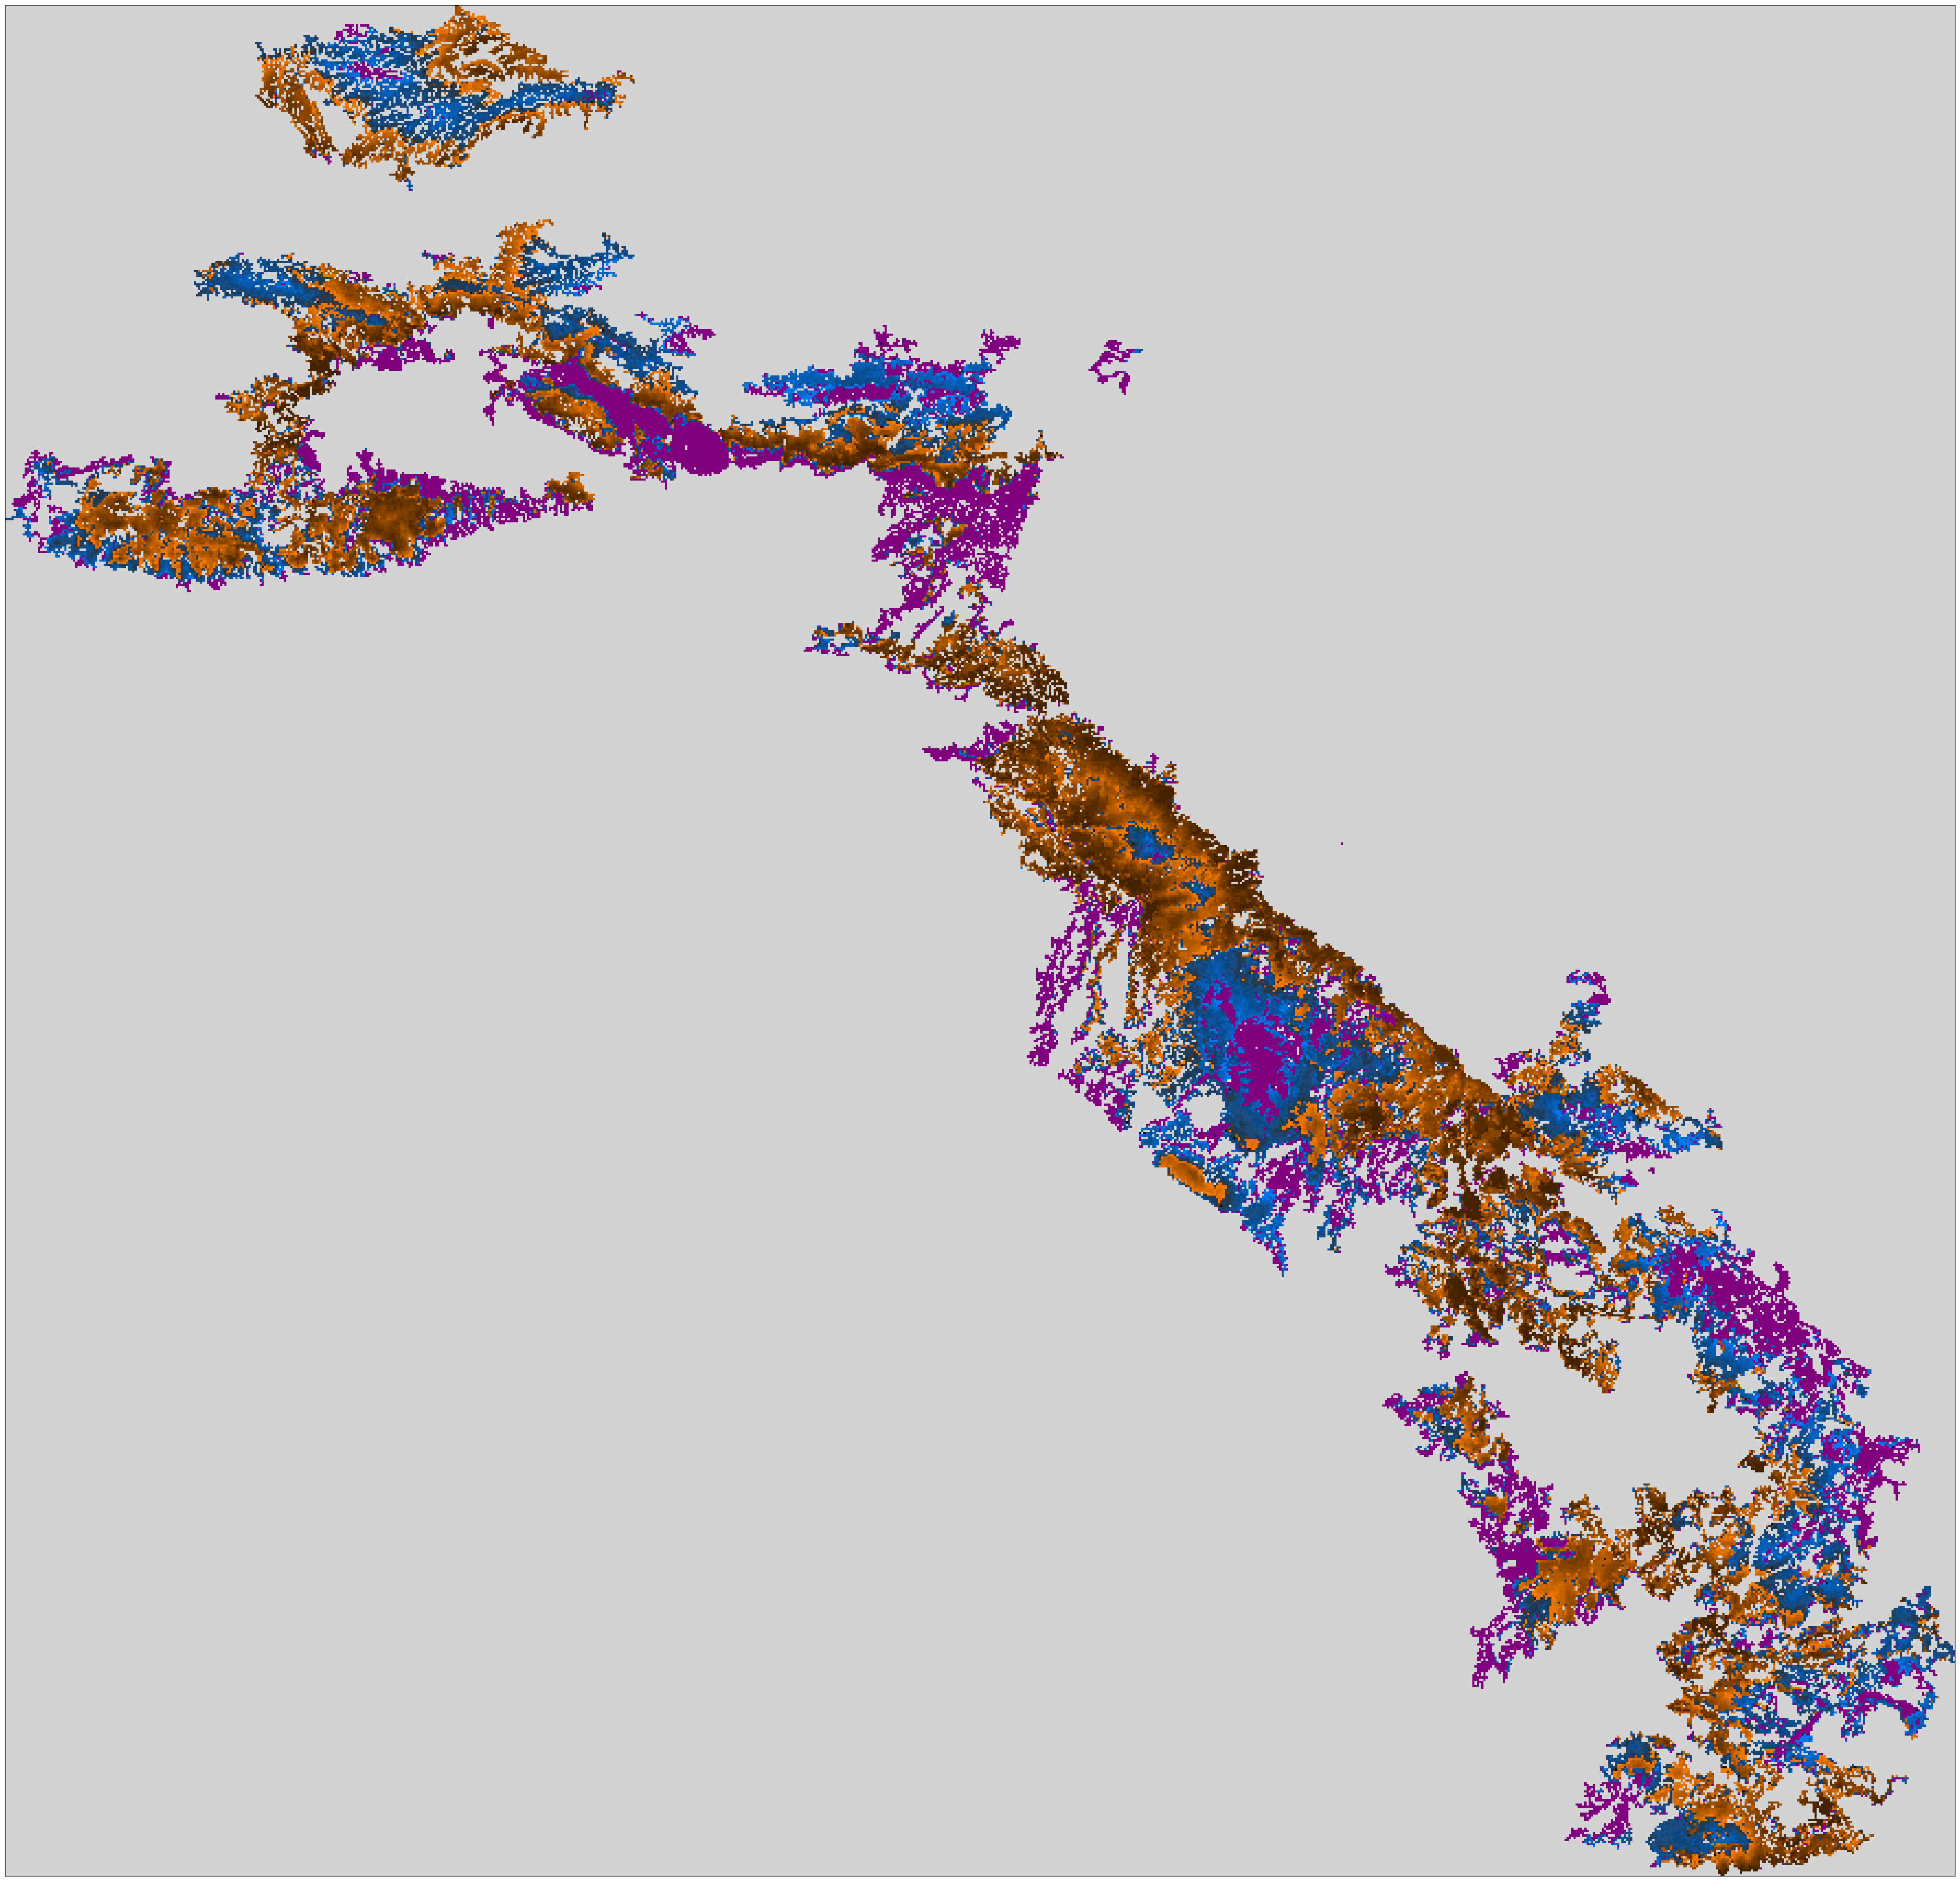

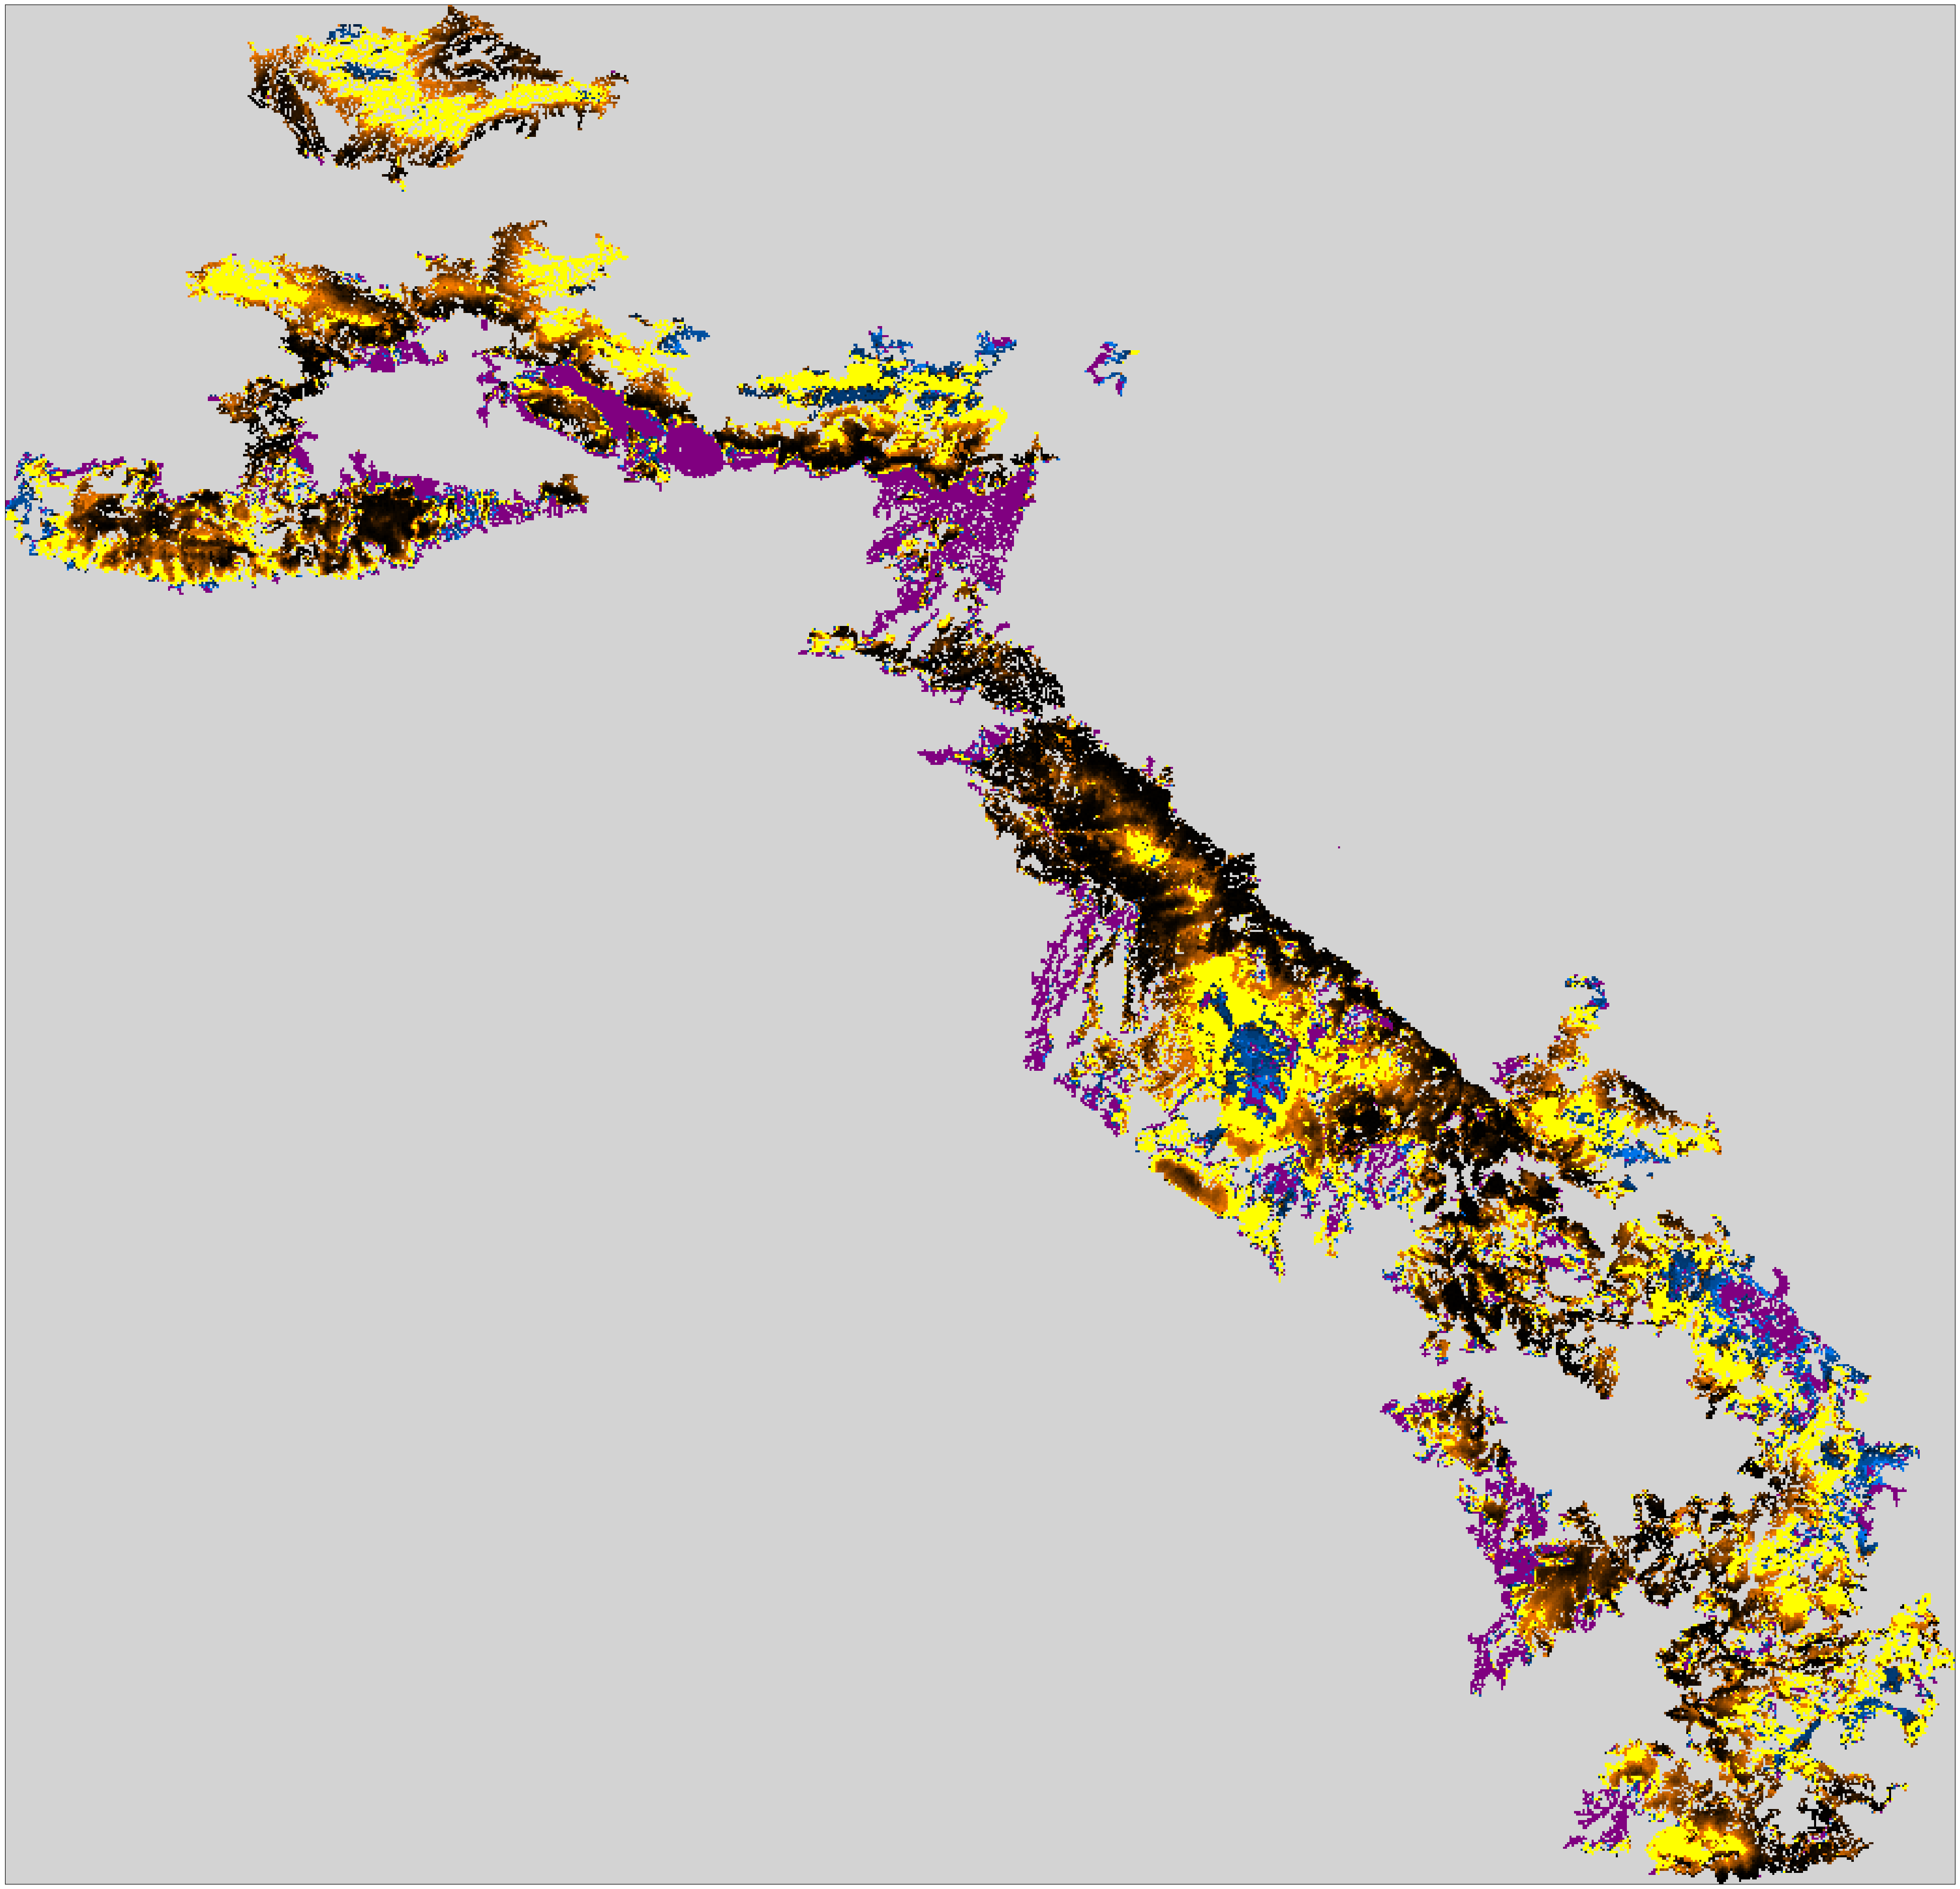

In [140]:
C_i = 9
for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    stepfit_T1 = np.load(fn_prefix + "stepfit_T1.npy")
    stepfit_T2 = np.load(fn_prefix + "stepfit_T2.npy")
    
    # Create the 2D colormap
    resolution = 500  # Number of points along each axis
    x = np.linspace(0, 1, resolution)  # X-axis range
    y = np.linspace(0, 1, resolution)  # Y-axis range
    X, Y = np.meshgrid(x, y)
    colormap = np.zeros((resolution, resolution, 3))
    colormap[..., 0] = X  # Red channel
    colormap[..., 1] = (X + Y) / 2  # Green channel (optional blend)
    colormap[..., 2] = Y  # Blue channel
    
    imshow_mat = np.ones(maps_filt.shape + (2,)) * np.nan
    mapi_sorted = mapindices[tau_argsort_ref].T
    # First populate cells with inclusions
    inclusion_filt = (stepfit_T1 > 0) & (stepfit_T1 <= 1)
    mapslice = mapi_sorted[:, inclusion_filt]
    imshow_mat[mapslice[0], mapslice[1], 0] = stepfit_T1[inclusion_filt]
    imshow_mat[mapslice[0], mapslice[1], 1] = stepfit_T2[inclusion_filt]
    # Now populate cells with exclusion
    exclusion_filt = (stepfit_T1 < 0)
    mapslice = mapi_sorted[:, exclusion_filt]
    '''Flip T1 and T2 to work with colormap'''
    imshow_mat[mapslice[0], mapslice[1], 0] = -1 * stepfit_T2[exclusion_filt]
    imshow_mat[mapslice[0], mapslice[1], 1] = -1 * stepfit_T1[exclusion_filt]
    # Create filters for always in/ex-cluded cells
    alwaysex_filt = (stepfit_T1 == 2)
    alwaysin_filt = (stepfit_T1 == 3)
    neverchanges_filt = (alwaysex_filt | alwaysin_filt) #(alwaysex_filt == False) & (alwaysin_filt == False)
    
    # Color the data
    mapslice = mapi_sorted[:, (neverchanges_filt == False)]
    rows = (imshow_mat[..., 0] * (resolution - 1)).astype(int)  # Row indices (scaled to colormap resolution)
    cols = (imshow_mat[..., 1] * (resolution - 1)).astype(int)  # Column indices (scaled to colormap resolution)
    colored_data = colormap[rows, cols]
    
    # Color always included
    mapslice = mapi_sorted[:, alwaysin_filt]
    kinfilt = np.count_nonzero(alwaysin_filt)
    colored_data[mapslice[0], mapslice[1], ...] = np.tile(colors.to_rgb('yellow'), kinfilt).reshape((kinfilt,3))
    
    # Color always excluded
    mapslice = mapi_sorted[:, alwaysex_filt]
    koutfilt = np.count_nonzero(alwaysex_filt)
    colored_data[mapslice[0], mapslice[1], ...] = np.tile(colors.to_rgb('purple'), koutfilt).reshape((koutfilt,3))
    
    # Color background
    colored_data[maps_filt == False] = colors.to_rgb('lightgrey')
    
    # Crop out border where all nans
    nonzero_indices = np.nonzero(~np.isnan(imshow_mat))
    row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
    col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
    colored_data = colored_data[row_min:row_max + 1, col_min:col_max + 1]
    
    fig, ax = plt.subplots(1, figsize=(50,50))
    im = ax.imshow(colored_data)
    ax.set_yticks([])
    ax.set_xticks([])
    
    fn = fig_prefix + f"newmap.png"
    fig.savefig(fn, bbox_inches='tight')
    # break

##### 2d colormap

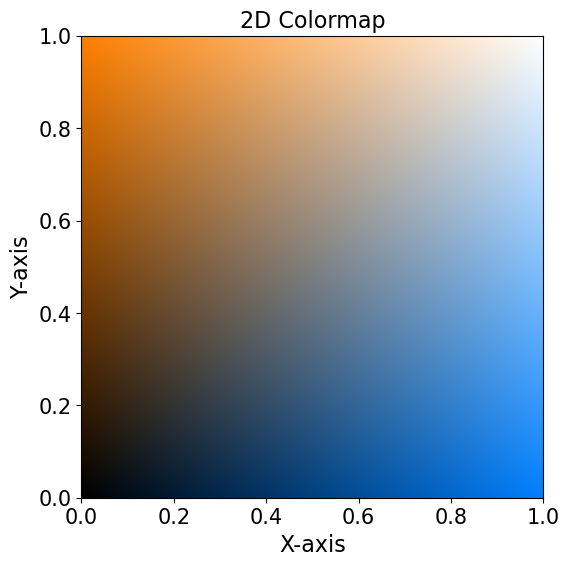

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the resolution of the colormap
resolution = 500  # Number of points along each axis

# x = np.linspace(-1, 1, resolution)
# y = np.linspace(-1, 1, resolution)
# X, Y = np.meshgrid(x, y)
# # Normalize the values to range from 0 to 1 for color mapping
# X_norm = (X + 1) / 2  # Map from [-1, 1] to [0, 1]
# Y_norm = (Y + 1) / 2  # Map from [-1, 1] to [0, 1]

x = np.linspace(0, 1, resolution)
y = np.linspace(0, 1, resolution)
X, Y = np.meshgrid(x, y)
X_norm = X
Y_norm = Y

# Create a colormap
colormap = np.zeros((resolution, resolution, 3))
colormap[..., 0] = X_norm  # Red channel
colormap[..., 1] = (X_norm + Y_norm) / 2  # Green channel (optional blend)
colormap[..., 2] = Y_norm  # Blue channel

# Display the colormap
plt.figure(figsize=(6, 6))
# plt.imshow(colormap, extent=(-1, 1, -1, 1))
# plt.imshow(np.rot90(colormap), extent=(-1, 1, -1, 1))
plt.imshow(np.rot90(colormap), extent=(0, 1, 0, 1))
plt.title('2D Colormap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(False)

##### Step function fitting

In [7]:
from ipywidgets import interact
import ipywidgets as widgets
'''Note these actually are fit for the indices of allowed values, not the y values themselves'''
def step_function1(x, threshold, value_low, value_high):
    return np.where(x < threshold, value_low, value_high)
def step_function2(x, threshold1, threshold2, value_btwn, value_out):
    return np.where((x >= threshold1) & (x < threshold2), value_btwn, value_out)
step_funcs = [step_function1, step_function2]
allowed_values = np.array([0, 1])
def stepfit1(X, y, y0_i):
    def mse_loss(params):
        """Mean squared error for the step function fit."""
        threshold = params[0]
        value_low = allowed_values[int(round(params[1]))]
        value_high = allowed_values[int(round(params[2]))]
        y_pred = step_function1(X, threshold, value_low, value_high)
        return np.mean((y - y_pred) ** 2)
    initial_guess = [0.5, 0.5, 0.5]
    bounds = [(X.min(), X.max()), (y0_i, y0_i), (0, allowed_values.size - 1)]
    result = scipy.optimize.differential_evolution(mse_loss, bounds)
    return result
def stepfit2(X, y, y0_i):
    def mse_loss(params):
        threshold1 = params[0]
        threshold2 = params[1]
        value_btwn = allowed_values[int(round(params[2]))]
        value_out = allowed_values[int(round(params[3]))]
        y_pred = step_function2(X, threshold1, threshold2, value_btwn, value_out)
        return np.mean((y - y_pred) ** 2)
    initial_guess = [0.5, 0.5, 0.5, 0.5]
    bounds = [(X.min(), X.max()), (X.min(), X.max()), (0, allowed_values.size - 1), (y0_i, y0_i)]
    result = scipy.optimize.differential_evolution(mse_loss, bounds)
    return result

C_i = 9
set_globals("gte_thresh_results")
maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
stepfit_values = np.load(fn_prefix + "stepfit_values.npy")
closest_thresh_i = np.load(fn_prefix + "closest_thresh_i.npy")
inoptima_vec = np.load(fn_prefix + "inoptima_vec.npy")

In [8]:
def plt_bestfit(k):
    # Perform step function fitting
    X = maxrob[:, C_i][closest_thresh_i]
    y = inoptima_vec[k]
    y0_i = np.argwhere(y[0] == allowed_values)[0][0]
    fit_results = [stepfit1(X,y,y0_i), stepfit2(X,y,y0_i)]
    best_fit_i = np.argmin([res.fun for res in fit_results])
    best_fit = fit_results[best_fit_i]

    # Plot the data and the fitted step function
    plt.scatter(X, y, label='Data', alpha=0.7)
    if best_fit_i == 0:
        plt.plot(
            X, 
            step_funcs[best_fit_i](X, best_fit.x[0], allowed_values[int(round(best_fit.x[1]))], 
                                   allowed_values[int(round(best_fit.x[2]))]),
            color='red', label='Fitted Step Function', linewidth=2
        )
    elif best_fit_i == 1:
        plt.plot(
            X, 
            step_funcs[best_fit_i](X, best_fit.x[0], best_fit.x[1], 
                                   allowed_values[int(round(best_fit.x[2]))], 
                                   allowed_values[int(round(best_fit.x[3]))]),
            color='red', label='Fitted Step Function', linewidth=2
        )
    plt.legend()
    plt.xlabel(r'$\omega$ requirement')
    plt.ylabel('In/Out of Optimum')
    plt.yticks([0,1])
    plt.show()
interact(plt_bestfit, k=(0, tau_flat.size-1, 1))

interactive(children=(IntSlider(value=43996, description='k', max=87992), Output()), _dom_classes=('widget-int…

<function __main__.plt_bestfit(k)>

#### Overpotted histograms

In [ ]:
tau_max = 80
color = 'orangered'
tau_step = np.diff(tau_vec)[0] / 2
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))

colormap = copy.copy(cm.copper)
vmin = 0; vmax = 1
normalize = colors.Normalize(vmin=vmin, vmax=vmax)

for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    figsize = (9,6)
    fig, ax = plt.subplots(1, figsize=figsize)

    # Plot the initial distribution
    ax.hist(tau_flat, bins=tau_edges, color=color, histtype='step', lw=3.5); 

    # Overplot optimal slices as metric thresh increases (and omega decreases)
    opt_ncell_vec = np.ones_like(rob_thresh_vec) * np.nan
    opt_sl_vec = np.ones_like(rob_thresh_vec) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if maxrob[thresh_i, C_i] < 1:
            opt_ncell_i = int(argmaxrob[thresh_i, C_i][0])
            opt_ncell_vec[thresh_i] = ncell_vec[opt_ncell_i]
            opt_sl_i = int(argmaxrob[thresh_i, C_i][1])
            opt_sl_vec[thresh_i] = slice_left_all[opt_sl_i]
            
    num_omega_samples, alpha = (3, 0.8)
    nan_filt = np.where(~np.isnan(opt_ncell_vec))
    opt_ncell_vec = opt_ncell_vec[nan_filt].astype(int)
    opt_sl_vec = opt_sl_vec[nan_filt].astype(int)
    indices = np.linspace(0, opt_ncell_vec.size - 1, num_omega_samples, dtype=int)
    # for i in np.arange(0, opt_ncell_vec.size, 1):
    for i in np.flip(indices):
        omega = maxrob[nan_filt[0][i], C_i]
        slice_color = colormap(normalize(omega))
        tau_slice = tau_sorted[opt_sl_vec[i]:opt_sl_vec[i]+opt_ncell_vec[i]]
        ax.hist(tau_slice, bins=tau_edges, color=slice_color, alpha=alpha);

    ax.set_yticks([])
    ax.set_ylabel(r"$\tau$ prevalence within species range")
    ax.set_xlabel(r"$\tau$")
    ax.set_xlim(15, tau_max);

In [ ]:
tau_max = 80
color = 'orangered'
tau_step = np.diff(tau_vec)[0] / 2
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))

colormap = copy.copy(cm.copper)
vmin = 0; vmax = 1
normalize = colors.Normalize(vmin=vmin, vmax=vmax)

for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    figsize = (9,6)
    fig, ax = plt.subplots(1, figsize=figsize)

    # Plot the initial distribution
    ax.hist(tau_flat, bins=tau_edges, color=color, histtype='step', lw=3.5); 

    # Overplot optimal slices as metric thresh increases (and omega decreases)
    opt_ncell_vec = np.ones_like(rob_thresh_vec) * np.nan
    opt_sl_vec = np.ones_like(rob_thresh_vec) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if maxrob[thresh_i, C_i] < 1:
            opt_ncell_i = int(argmaxrob[thresh_i, C_i][0])
            opt_ncell_vec[thresh_i] = ncell_vec[opt_ncell_i]
            opt_sl_i = int(argmaxrob[thresh_i, C_i][1])
            opt_sl_vec[thresh_i] = slice_left_all[opt_sl_i]
            
    num_omega_samples, alpha = (10, 0.2)
    nan_filt = np.where(~np.isnan(opt_ncell_vec))
    opt_ncell_vec = opt_ncell_vec[nan_filt].astype(int)
    opt_sl_vec = opt_sl_vec[nan_filt].astype(int)
    indices = np.linspace(0, opt_ncell_vec.size - 1, num_omega_samples, dtype=int)
    # for i in np.arange(0, opt_ncell_vec.size, 1):
    for i in np.flip(indices):
        omega = maxrob[nan_filt[0][i], C_i]
        slice_color = colormap(normalize(omega))
        tau_slice = tau_sorted[opt_sl_vec[i]:opt_sl_vec[i]+opt_ncell_vec[i]]
        ax.hist(tau_slice, bins=tau_edges, color=color, alpha=alpha);

    ax.set_yticks([])
    ax.set_ylabel(r"$\tau$ prevalence within species range")
    ax.set_xlabel(r"$\tau$")
    ax.set_xlim(15, tau_max);

#### Remake optima phase with tau_i on x axis

In [ ]:
fig, ax = plt.subplots(1, figsize=(11,7))
colormap = copy.copy(cm.copper)
vmin = 0; vmax = 1
normalize = colors.Normalize(vmin=vmin, vmax=vmax)
colormap_2 = copy.copy(cm.YlGn_r)
normalize_2 = colors.Normalize(vmin=vmin, vmax=vmax)
C_i = 9
markers = ['o', '^']
res_labs = [f'$<{metric}>_{{meta}}$', f'$P(<{metric}>_k \geq 0.5)$']
for res_i, results_pre in enumerate(['meta_mean_results', 'gte_thresh_results']):
    set_globals(results_pre)
    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
    
    opt_ncell = np.ones_like(rob_thresh_vec) * np.nan
    opt_sl = np.ones_like(rob_thresh_vec) * np.nan
    opt_taui = np.ones_like(rob_thresh_vec) * np.nan
    for thresh_i, thresh in enumerate(rob_thresh_vec):
        if maxrob[thresh_i, C_i] < 1:
            opt_ncell_i = int(argmaxrob[thresh_i, C_i][0])
            opt_ncell[thresh_i] = ncell_vec[opt_ncell_i]
            opt_sl_i = int(argmaxrob[thresh_i, C_i][1])
            opt_sl[thresh_i] = slice_left_all[opt_sl_i]
            opt_taui[thresh_i] = np.mean(tau_sorted[opt_sl_i:opt_sl_i+opt_ncell_i])
    opt_ncell = opt_ncell / ncell_tot
    opt_sl = opt_sl / ncell_tot
    scatter = ax.scatter(opt_taui, opt_ncell, cmap=colormap, norm=normalize, c=maxrob[:, C_i], marker=markers[res_i], s=200)
    ax.scatter([], [], c='k', marker=markers[res_i], label=res_labs[res_i])
cbar = fig.colorbar(scatter, ax=ax, location="right", shrink=0.8)
cbar.set_label(r"$\omega$ requirement", rotation=-90, labelpad=30)
ax.set_ylabel(fr"optimal range fraction for intervention")
ax.set_xlabel(fr"optimal average initial tau")
ax.legend()
# ymin = -0.05; ymax = 1
xmin = min(slice_left_all/ncell_tot) - np.diff(slice_left_all/ncell_tot)[0]
# xmax = max(slice_left_all/ncell_tot)
xmax = slice_left_all[-23]/ncell_tot
# ax.set_xlim(xmin,xmax)
# ymin = min(ncell_vec/ncell_tot)
# ymax = max(ncell_vec/ncell_tot)
ymin = ncell_vec[6] / ncell_tot
ymax = ncell_vec[-5] / ncell_tot
ax.set_ylim(ymin, ymax)
ncell_constraint = 1 - (slice_left_all/ncell_tot)
# fn = f"shared_figs/comparing_optima.png"
# fig.savefig(fn, bbox_inches='tight')

### $\epsilon$ correlations

#### Correlations as $n_{cell}$ or $sl$ change

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
results_pre = "meta_mean_results"
set_globals(results_pre)
phase_full = np.load(fn_prefix + "phase_full.npy")
C_i = 9
num_eps = len(eps_axes.items())
eps_labels = ["|$\mu_T$|", "$|\mu_{\hat{T}}|$", "$\sigma_T$", "$\sigma_{\hat{T}}$"]
color_vec = ['#66CCEE', '#EE6677', '#4477AA', '#AA3377']
for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
    plot_vec = np.ones(ncell_vec.size) * np.nan
    for ncell_i, ncell in enumerate(ncell_vec):
        all_x = []
        all_y = []
        for eps_val_i, eps_val in enumerate(eps_ax):
            eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
            full_slice = eps_slice + (C_i, ncell_i, slice(None))
            phase_slice = phase_full[full_slice]
            flat_nonan = phase_slice.ravel()[~np.isnan(phase_slice.ravel())]
            all_y.append(flat_nonan.tolist())
            all_x.append(np.repeat(np.abs(eps_val), len(flat_nonan)).tolist())
        spear = scipy.stats.spearmanr(a=np.array(all_x).flatten(), b=np.array(all_y).flatten())
        plot_vec[ncell_i] = spear.statistic
    ax.plot(ncell_vec/ncell_tot, plot_vec, label=eps_labels[eps_ax_i], marker='o', color=color_vec[eps_ax_i])
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlim(0, 1)
ax.set_xlabel(r"fraction of species range where $\tau$ altered")
ax.set_ylabel(rf"{metric_lab} correlation to $\epsilon$ axes")
ax.set_title(fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}")
fn = fig_prefix + f"epscorr.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,6))
results_pre = "meta_mean_results"
set_globals(results_pre)
phase_full = np.load(fn_prefix + "phase_full.npy")
C_i = 9
num_eps = len(eps_axes.items())
eps_labels = ["|$\mu_T$|", "$|\mu_{\hat{T}}|$", "$\sigma_T$", "$\sigma_{\hat{T}}$"]
color_vec = ['#66CCEE', '#EE6677', '#4477AA', '#AA3377']
for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
    plot_vec = np.ones(slice_left_all.size) * np.nan
    for sl_i, sl in enumerate(slice_left_all):
        all_x = []
        all_y = []
        for eps_val_i, eps_val in enumerate(eps_ax):
            eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
            full_slice = eps_slice + (C_i, slice(None), sl_i)
            phase_slice = phase_full[full_slice]
            flat_nonan = phase_slice.ravel()[~np.isnan(phase_slice.ravel())]
            all_y.append(flat_nonan.tolist())
            all_x.append(np.repeat(np.abs(eps_val), len(flat_nonan)).tolist())
        spear = scipy.stats.spearmanr(a=np.array(all_x).flatten(), b=np.array(all_y).flatten())
        plot_vec[sl_i] = spear.statistic
    ax.plot(slice_left_all/ncell_tot, plot_vec, label=eps_labels[eps_ax_i], marker='o', color=color_vec[eps_ax_i], alpha=1)
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlim(0, 1)
ax.set_xlabel(r"initial index of slice where $\tau$ altered")
ax.set_ylabel(rf"{metric_lab} correlation to $\epsilon$ axes")
ax.set_title(fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}")
fn = fig_prefix + f"epscorr.png"
# fig.savefig(fn, bbox_inches='tight')

#### Correlations at optima across $\omega$ requirements

In [ ]:
for results_pre in ["meta_mean_results", "gte_thresh_results"]:
    set_globals(results_pre)
    fig, ax = plt.subplots(1, figsize=(8,6))
    phase_full = np.load(fn_prefix + "phase_full.npy")
    C_i = 9
    num_eps = len(eps_axes.items())
    eps_labels = ["|$\mu_T$|", "$|\mu_{\hat{T}}|$", "$\sigma_T$", "$\sigma_{\hat{T}}$"]
    color_vec = ['#66CCEE', '#EE6677', '#4477AA', '#AA3377']

    maxrob = np.load(fn_prefix + "maxrob.npy")
    argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
    rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")

    for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
        plot_vec = np.ones(rob_thresh_vec.size) * np.nan
        for thresh_i, thresh in enumerate(rob_thresh_vec):
            # Skip points where max omega = 1 bc can't find optima
            if maxrob[thresh_i, C_i] == 1: continue
            opt_ncell_i = int(argmaxrob[thresh_i, C_i][0])
            opt_sl_i = int(argmaxrob[thresh_i, C_i][1])
            all_x = []
            all_y = []
            for eps_val_i, eps_val in enumerate(eps_ax):
                eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
                full_slice = eps_slice + (C_i, opt_ncell_i, opt_sl_i)
                phase_slice = phase_full[full_slice]
                flat_nonan = phase_slice.ravel()[~np.isnan(phase_slice.ravel())]
                all_y.append(flat_nonan.tolist())
                all_x.append(np.repeat(np.abs(eps_val), len(flat_nonan)).tolist())
            '''Try normalizing x axis by max val'''
            all_x = np.array(all_x).flatten()
            all_x = all_x / all_x.max()
            spear = scipy.stats.spearmanr(a=all_x, b=np.array(all_y).flatten())
            plot_vec[thresh_i] = spear.statistic
        # if results_pre == "meta_mean_results":
        #     spacing = 4
        # elif results_pre == "gte_thresh_results":
        #     spacing = 3
        spacing = 1
        # ax.plot(rob_thresh_vec[::spacing], plot_vec[::spacing], label=eps_labels[eps_ax_i], marker='o', color=color_vec[eps_ax_i], alpha=1)
        ax.plot(maxrob[:, C_i][::spacing], plot_vec[::spacing], label=eps_labels[eps_ax_i], marker='o', color=color_vec[eps_ax_i], alpha=1)
    ax.axhline(0, ls='--', c='k')
    ax.legend()
    ax.set_xlabel(r"$\omega$ requirement")
    ax.set_ylabel(rf"{metric_lab} correlation to $\epsilon$ axes @ optima")
    ax.set_title(fr"$C~/~k_{{max}}=${np.round(C_vec[C_i]/ncell_tot, 1)}")
    min_omega_i = np.nonzero(~np.isnan(plot_vec))[0].min()
    # ax.set_xlim(rob_thresh_vec[min_omega_i], 1.01)
    fn = fig_prefix + f"epscorr_omega_{results_pre}.png"
    fig.savefig(fn, bbox_inches='tight')

#### Phase

In [ ]:
results_pre = "meta_mean_results"
set_globals(results_pre)
phase_full = np.load(fn_prefix + "phase_full.npy")
C_i = 9
num_eps = len(eps_axes.items())
eps_labels = ["|$\mu_T$|", "$|\mu_{\hat{T}}|$", "$\sigma_T$", "$\sigma_{\hat{T}}$"]
color_vec = ['#66CCEE', '#EE6677', '#4477AA', '#AA3377']
# colormap = copy.copy(cm.RdPu_r)
colormap = copy.copy(cm.PiYG)

# Get optima points
maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
opt_ncell_i = np.ones_like(rob_thresh_vec) * np.nan
opt_sl_i = np.ones_like(rob_thresh_vec) * np.nan
for thresh_i, thresh in enumerate(rob_thresh_vec):
    if maxrob[thresh_i, C_i] < 1:
        opt_ncell_i[thresh_i] = int(argmaxrob[thresh_i, C_i][0])
        opt_sl_i[thresh_i] = int(argmaxrob[thresh_i, C_i][1])
colormap_2 = copy.copy(cm.copper)
normalize_2 = colors.Normalize(vmin=0, vmax=1)
edge_colors = colormap_2(normalize_2(maxrob[:, C_i]))
spacing = 4

for eps_ax_i, eps_ax in enumerate(eps_axes.values()):
    fig, ax = plt.subplots(1, figsize=(10,8))
    imshow_mat = np.ones((ncell_vec.size, slice_left_all.size)) * np.nan
    for (ncell_i, ncell), (sl_i, sl) in product(enumerate(ncell_vec), enumerate(slice_left_all)):
        all_x = []
        all_y = []
        for eps_val_i, eps_val in enumerate(eps_ax):
            eps_slice = tuple([slice(None) if i != eps_ax_i else eps_val_i for i in range(num_eps)])
            full_slice = eps_slice + (C_i, ncell_i, sl_i)
            phase_slice = phase_full[full_slice]
            flat_nonan = phase_slice.ravel()[~np.isnan(phase_slice.ravel())]
            all_y.append(flat_nonan.tolist())
            all_x.append(np.repeat(np.abs(eps_val), len(flat_nonan)).tolist())
        spear = scipy.stats.spearmanr(a=np.array(all_x).flatten(), b=np.array(all_y).flatten())
        imshow_mat[ncell_i, sl_i] = spear.statistic
    vmin = -1; vmax = 1
    normalize = colors.Normalize(vmin=vmin, vmax=vmax)
    im = ax.imshow(np.flip(imshow_mat, axis=0), cmap=colormap, norm=normalize)
    ax.set_xlabel(r"initial index of slice where $\tau$ altered")
    ax.set_ylabel(r"fraction of range where $\tau$ altered")
    ytick_spacing = 3
    yticks = np.arange(0, len(ncell_vec), ytick_spacing)
    ytick_labels = np.flip(np.round(ncell_vec/ncell_tot, 2))
    ax.set_yticks(yticks, labels=ytick_labels[::ytick_spacing]);
    xtick_spacing = 6
    xticks = np.arange(0, len(slice_left_all), xtick_spacing)
    xtick_labels = np.round(slice_left_all/ncell_tot, 2)
    ax.set_xticks(xticks, labels=xtick_labels[::xtick_spacing]);
    ax.set_title(eps_labels[eps_ax_i])
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
    cbar.ax.set_ylabel(rf'Spearman', rotation=-90, labelpad=20)

    ax.scatter(opt_sl_i[::spacing], ncell_vec.size - opt_ncell_i[::spacing], 
                facecolor=edge_colors[::spacing], s=150, 
                linewidths=2, marker='x')
    fn = fig_prefix + f"eps_corr_phase_{list(eps_axes.keys())[eps_ax_i]}.png"
    fig.savefig(fn, bbox_inches='tight')

### $\text{max}(<\text{metric}_{meta}>$ under $\epsilon=0$

In [ ]:
with h5py.File(fn_prefix + "/phase_flat.h5", "r") as phase_handle:
    data_key = "0.0/0.0/0.0/0.0/phase"
    phase_slice_zeroeps = phase_handle[data_key][:]
    nochange_zeroeps = phase_handle["0.0/0.0/0.0/0.0/metric_nochange"][()]

In [ ]:
fig, ax = plt.subplots(1, figsize=(11,8))

plot_vec = np.ones_like(C_vec) * np.nan
c_vec = np.ones_like(C_vec) * np.nan
for C_i, C in enumerate(C_vec):
    argmax = np.nanargmax(phase_slice_zeroeps[C_i, :, :])
    optimal_param_i = np.unravel_index(argmax, phase_slice_zeroeps.shape[1:])
    # print(C_i, optimal_param_i)
    plot_vec[C_i] = phase_slice_zeroeps[C_i, optimal_param_i[0], optimal_param_i[1]]
    c_vec[C_i] = ncell_vec[optimal_param_i[0]]
c_vec = c_vec / ncell_tot
vmax = np.nanmax(c_vec); vmin = np.nanmin(c_vec)
vmin = 0; vmax = 1
vmin = min(ncell_vec) / ncell_tot; vmax = max(ncell_vec) / ncell_tot
norm = colors.Normalize(vmin=vmin, vmax=vmax)
colormap = copy.copy(cm.RdPu_r)
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
bar_colors = colormap(norm(c_vec))
bar = ax.bar(np.arange(C_vec.size), plot_vec, color=bar_colors)
cbar = plt.colorbar(sm, label='Color Scale Value', ax=ax)
cbar.set_label(fr"optimal fraction of range for intervention", rotation=-90, labelpad=30)
ax.set_ylim(nochange_zeroeps, 1.05*np.max(plot_vec))
ax.set_ylabel(fr"$\text{{max}}(${metric_lab}$)$")
xtick_spacing = 1
xticks = np.arange(0, len(C_vec), xtick_spacing)
ax.set_xticks(xticks, labels=np.round((C_vec/(ncell_tot))[::xtick_spacing], 1));
ax.set_xlabel(r"shift in $\tau$ per cell if spread across entire range $({C}~/~{k_{max}})$")

fn = fig_prefix + f"maxmetric_C_zeroeps.png"
fig.savefig(fn, bbox_inches='tight')

### Visualize fire regime change

In [ ]:
# Read in maps and convert fdm to tau
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1], 
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt] #+ (max(C_vec)/ncell_tot)
tau_flat[tau_flat > max(tau_vec)] = max(tau_vec)
tau_argsort = np.argsort(tau_flat)

#### Shift examples

In [ ]:
figsize = (9,6)
fig, ax = plt.subplots(1, figsize=figsize)
tau_max = 80
color = 'orangered'
tau_step = np.diff(tau_vec)[0] / 2
tau_edges = np.concatenate(([0], np.arange(tau_step/2, tau_vec[-1]+tau_step, tau_step)))
ax.hist(tau_flat, bins=tau_edges, color=color, histtype='step', lw=3.5); 
ncell = 50_000
# ncell = 19_000
sl = 11_000
tau_slice = tau_flat[tau_argsort][sl:sl+ncell]
ax.hist(tau_slice, bins=tau_edges, color=color, alpha=0.5);
ax.set_yticks([])
ax.set_ylabel(r"$\tau$ prevalence within species range")
ax.set_xlabel(r"$\tau$")
ax.set_xlim(15, tau_max);
# fn = f"figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/maxmetric_C_zeroeps.png"
fn = f"{results_pre}/figs/taudist_preshift_{ncell}.png"
fig.savefig(fn, bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=figsize)
tauc = max(C_vec) / ncell
tau_shifted = tau_flat[tau_argsort].copy()
tau_shifted[sl:sl+ncell] += tauc
ax.hist(tau_shifted, bins=tau_edges, color=color, histtype='step', lw=3.5); 
ax.hist(tau_slice+tauc, bins=tau_edges, color=color, alpha=0.5);
ax.set_yticks([])
ax.set_ylabel(r"$\tau$ prevalence within species range")
ax.set_xlabel(r"$\tau$")
ax.set_xlim(15, tau_max);
fn = f"{results_pre}/figs/taudist_postshift_{ncell}.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
# Make Bspline interpolation for <metric>
metric_expect_vec = np.ones(tau_vec.size) * np.nan
for tau_i, tau in enumerate(tau_vec):
    tau_filt = (all_tau == tau)
    metric_slice = all_metric[tau_filt]
    metric_expect_vec[tau_i] = np.mean(metric_slice)
t = tau_vec[2:-2:1] 
k = 3
t = np.r_[(0,)*(k+1), t, (tau_vec[-1],)*(k+1)]
spl = make_lsq_spline(tau_vec[1:], metric_expect_vec[1:], t, k)

# Vizualise distribution of $<\text{metric}>$
figsize = (9,6)
fig, ax = plt.subplots(1, figsize=figsize)
color = 'limegreen'
mlab = "$<P_s>_k$"
ax.hist(spl(tau_flat[tau_flat < tau_max]), bins=120, color=color, histtype='step', lw=3.5); 
ax.set_yticks([])
ax.set_ylabel(rf"{mlab} frequency")
ax.set_xlabel(rf"{mlab}")
fn = fig_prefix + f"metricdist_preshift_{ncell}.png"
fig.savefig(fn, bbox_inches='tight')

fig, ax = plt.subplots(1, figsize=figsize)
ax.hist(spl(tau_shifted[tau_shifted < tau_max]), bins=120, color=color, histtype='step', lw=3.5); 
ax.set_yticks([])
ax.set_ylabel(rf"{mlab} frequency")
ax.set_xlabel(rf"{mlab}")
fn = fig_prefix + f"/metricdist_postshift_{ncell}.png"
fig.savefig(fn, bbox_inches='tight')

#### Map change optimizing $\omega$ instead of $\text{metric}_\text{meta}$

In [ ]:
mapindices = np.argwhere(maps_filt)
C_i = 9
num_samples = 5

flat = phase_slice_zeroeps[C_i].ravel()
non_nan_i = np.where(~np.isnan(flat))[0]
flat_sort = non_nan_i[np.argsort(flat[non_nan_i])]
phase_sorted_i = np.unravel_index(flat_sort, phase_slice_zeroeps[C_i].shape)
phase_sorted_i = list((zip(phase_sorted_i[0], phase_sorted_i[1])))
tot_samples = len(phase_sorted_i)
# num_samples = int(tot_samples * 0.025)
print(num_samples)
print(phase_sorted_i[-num_samples:])
tot_tauc_k = np.zeros(maps_filt.shape)
n_k = np.zeros(maps_filt.shape)
tauc_relative = np.zeros(maps_filt.shape)
for i in range(tot_samples - num_samples, tot_samples):
    ncell = ncell_vec[phase_sorted_i[i][0]]
    sl = slice_left_all[phase_sorted_i[i][1]]
    map_slice = mapindices[tau_argsort][sl:sl+ncell]
    for map_i in map_slice:
        tot_tauc_k[map_i[0],map_i[1]] += (C_vec[C_i] / ncell)
        n_k[map_i[0],map_i[1]] += 1
        tauc_relative[map_i[0],map_i[1]] += (C_vec[C_i] / ncell) / tau_raster[map_i[0],map_i[1]]
avg_tauc_k = tot_tauc_k / n_k
tauc_relative = tauc_relative / n_k
np.save(fn_prefix + 'avg_tauc_k.npy', avg_tauc_k)
np.save(fn_prefix + 'tauc_relative.npy', tauc_relative)

target = 0.5
target_i = np.argmin(np.abs(rob_thresh_vec - target))
target = rob_thresh_vec[target_i]
flat = allrob[target_i, C_i].ravel()
non_nan_i = np.where(~np.isnan(flat))[0]
flat_sort = non_nan_i[np.argsort(flat[non_nan_i])]
rob_sorted_i = np.unravel_index(flat_sort, allrob[target_i, C_i].shape)
rob_sorted_i = list((zip(rob_sorted_i[0], rob_sorted_i[1])))
tot_samples = len(rob_sorted_i)
# num_samples = int(tot_samples * 0.05)
print(num_samples)
print(rob_sorted_i[-num_samples:])
tot_tauc_k_rob = np.zeros(maps_filt.shape)
n_k_rob = np.zeros(maps_filt.shape)
tauc_relative_rob = np.zeros(maps_filt.shape)
for i in range(tot_samples - num_samples, tot_samples):
    ncell = ncell_vec[rob_sorted_i[i][0]]
    sl = slice_left_all[rob_sorted_i[i][1]]
    map_slice = mapindices[tau_argsort][sl:sl+ncell]
    for map_i in map_slice:
        tot_tauc_k_rob[map_i[0],map_i[1]] += (C_vec[C_i] / ncell)
        n_k_rob[map_i[0],map_i[1]] += 1
        tauc_relative_rob[map_i[0],map_i[1]] += (C_vec[C_i] / ncell) / tau_raster[map_i[0],map_i[1]]
avg_tauc_k_rob = tot_tauc_k_rob / n_k_rob
tauc_relative_rob = tauc_relative_rob / n_k_rob
np.save(fn_prefix + 'avg_tauc_k_rob.npy', avg_tauc_k_rob)
np.save(fn_prefix + 'tauc_relative_rob.npy', tauc_relative_rob)

In [ ]:
[(7, 17), (8, 14), (8, 15), (8, 17), (8, 16)]

In [ ]:
figsize = (9,6)
fig, ax = plt.subplots(1, figsize=figsize)
tau_max = 80

ax.hist(tau_flat, bins=tau_edges, color='orangered', histtype='step', lw=3.5); 

ncell_i, sl_i = phase_sorted_i[-1]
ncell = ncell_vec[ncell_i]
sl = slice_left_all[sl_i]
tau_slice = tau_flat[tau_argsort][sl:sl+ncell]
ax.hist(tau_slice, bins=tau_edges, color='red', alpha=0.5,
        label=rf'optimizing {metric_lab}');

ncell_i, sl_i = rob_sorted_i[-1]
ncell = ncell_vec[ncell_i]
sl = slice_left_all[sl_i]
tau_slice = tau_flat[tau_argsort][sl:sl+ncell]
ax.hist(tau_slice, bins=tau_edges, color='blue', alpha=0.5, 
        label=rf'optimizing $\omega$ at {metric_lab}$=${np.round(target, 2)}');

ax.set_yticks([])
ax.set_ylabel(r"$\tau$ prevalence within species range")
ax.set_xlabel(r"$\tau$")
ax.set_xlim(15, tau_max);
ax.legend()
fn = fig_prefix + f"optimization_diff.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

# First replace nans with 0 so we can subtract
imshow_mat = np.where(np.isnan(tauc_relative_rob), 0, tauc_relative_rob) - np.where(np.isnan(tauc_relative), 0, tauc_relative)
# Now make pixels not in either map nan
nan_pixel_filt = np.isnan(tauc_relative_rob) & np.isnan(tauc_relative)
imshow_mat[nan_pixel_filt] = np.nan
# Multiply by 100 to get % change
imshow_mat = imshow_mat * 100
# Crop out border where all nans
nonzero_indices = np.nonzero(~np.isnan(imshow_mat))
row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
imshow_mat = imshow_mat[row_min:row_max + 1, col_min:col_max + 1]

vmin = np.nanmin(imshow_mat); vmax = np.nanmax(imshow_mat)
vlim = max([np.abs(extrema) for extrema in [vmin, vmax]])
center = 0
cmap = cm.PuOr.copy()
# cmap = cm.PiYG.copy()
norm = colors.TwoSlopeNorm(vmin=-vlim, vcenter=center, vmax=vlim)
cmap.set_bad(color='black', alpha=0.3)
imshow = ax.imshow(imshow_mat, cmap=cmap, norm=norm)
cbar = fig.colorbar(imshow, ax=ax, location="right", shrink=0.8)
ax.set_xlabel(fr"% change in $\tau$ optimizing robustness instead of stability")
ax.set_xticks([])
ax.set_yticks([])
fn = fig_prefix + f"map_example_1.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))

# First replace nans with 0 so we can subtract
imshow_mat = np.where(np.isnan(avg_tauc_k_rob), 0, avg_tauc_k_rob) - np.where(np.isnan(avg_tauc_k), 0, avg_tauc_k)
# Now make pixels not in either map nan
nan_pixel_filt = np.isnan(avg_tauc_k_rob) & np.isnan(avg_tauc_k)
imshow_mat[nan_pixel_filt] = np.nan
# Crop out border where all nans
nonzero_indices = np.nonzero(~np.isnan(imshow_mat))
row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
imshow_mat = imshow_mat[row_min:row_max + 1, col_min:col_max + 1]

vmin = np.nanmin(imshow_mat); vmax = np.nanmax(imshow_mat)
vlim = max([np.abs(extrema) for extrema in [vmin, vmax]])
center = 0
cmap = cm.PuOr.copy()
# cmap = cm.PiYG.copy()
norm = colors.TwoSlopeNorm(vmin=-vlim, vcenter=center, vmax=vlim)
cmap.set_bad(color='black', alpha=0.3)
imshow = ax.imshow(imshow_mat, cmap=cmap, norm=norm)
cbar = fig.colorbar(imshow, ax=ax, location="right", shrink=0.8)
ax.set_xlabel(fr"Change in $\hat{{\tau}}$ optimizing robustness instead of stability")
ax.set_xticks([])
ax.set_yticks([])
fn = fig_prefix + f"map_example.png"
fig.savefig(fn, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(10,10))
imshow_mat = np.where(maps_filt, tau_raster, np.nan)
# ax.imshow(imshow_mat, norm=colors.LogNorm(vmin=np.nanmin(imshow_mat), vmax=np.nanmax(imshow_mat)-160))
ax.imshow(np.where(maps_filt, fdm, np.nan))

In [ ]:
plt.hist(np.where(maps_filt, fdm, np.nan).ravel(), bins=30);

### Visualize $P(\text{metric}|\tau)$

In [ ]:
metric_edges = np.linspace(0, 1, 50)
metric_hist = np.histogram2d(all_tau, all_metric, bins=[tau_edges[::2], metric_edges], density=False)
fig, ax = plt.subplots(figsize=(10,8))
cmap = copy.copy(cm.YlGn)
cmap.set_bad(cmap(0.0))
imshow_mat = np.flip(np.transpose(metric_hist[0]), axis=0)
samples_per_tau = int(len(all_metric)/len(b_vec))
imshow_mat = imshow_mat / samples_per_tau
smoothed = scipy.ndimage.gaussian_filter(imshow_mat, sigma=0.125)
im = ax.imshow(imshow_mat, cmap=cmap,
              norm=colors.LogNorm(vmax=1), interpolation="nearest")
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel(rf'Frequency of $P_s$ given ${{\tau}}$', 
                   rotation=-90, labelpad=20)
ytick_spacing = 10
ytick_labels = np.flip(metric_hist[2])[::ytick_spacing]
yticks = np.arange(0,len(metric_hist[2]),ytick_spacing)
ax.set_yticks(yticks, labels=np.round(ytick_labels, decimals=1));
ax.set_ylabel(rf'$P_s$')
xtick_spacing = 10
xtick_labels = np.round(metric_hist[1][::xtick_spacing],1)
xticks = np.arange(0,len(metric_hist[1]),xtick_spacing)
ax.set_xticks(xticks, labels=xtick_labels);
ax.set_xlabel(r'$\tau$')
ax.set_xlim(1, imshow_mat.shape[1]-1)
fn = fig_prefix + f"Pmetric_given_tau.png"
fig.savefig(fn, bbox_inches='tight')